# Лабораторная работа 2. Ассоциативные правила

## 1. Введение

**Цель работы:** исследование методов анализа ассоциативных правил.

**Постановка задачи:**

Провести исследование методов анализа ассоциативных правил на датасете с Kaggle:

1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах.

2. Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др. 

3. Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

4. Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.

5. Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.

6. Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

7. Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.

8. Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.

## 2. Анализ данных

### Описание датасета

В работе используется датасет Online Retail Data Set from ML Repository, подготовленный на основе данных из Kaggle. Он содержит сведения о товарах, которые покупатели приобретали совместно в рамках одной покупки. Данные представлены в формате CSV и включают несколько колонок, каждая из которых соответствует позиции товара в корзине. Каждая строка отражает одну транзакцию, то есть набор товаров, купленных одновременно.

Датасет включает следующие элементы:

- Item_1, Item_2, Item_3 … - наименования товаров, входящих в корзину (категориальные значения);
- NaN-поля - отсутствие товара в соответствующей позиции;
- Повторяющиеся комбинации - частые наборы товаров, позволяющие строить ассоциативные правила.

В составе данных встречаются товары повседневного спроса, такие как Bread, Meat, Cheese, Eggs, Wine, Milk, Pencil и Diaper. Датасет содержит несколько сотен транзакций различной длины - от коротких корзин с 2-3 товарами до более полных наборов из 6-7 покупок. Такие данные позволяют выявлять связи между товарами, определять часто встречающиеся сочетания и проводить анализ ассоциативных правил с помощью алгоритмов Apriori и FPGrowth.

### Загрузка данных

Загрузим данные из датасета:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

all_data = pd.read_csv('retail_dataset.csv')
print(all_data)


          0       1       2       3       4       5       6
0     Bread    Wine    Eggs    Meat  Cheese  Pencil  Diaper
1     Bread  Cheese    Meat  Diaper    Wine    Milk  Pencil
2    Cheese    Meat    Eggs    Milk    Wine     NaN     NaN
3    Cheese    Meat    Eggs    Milk    Wine     NaN     NaN
4      Meat  Pencil    Wine     NaN     NaN     NaN     NaN
..      ...     ...     ...     ...     ...     ...     ...
310   Bread    Eggs  Cheese     NaN     NaN     NaN     NaN
311    Meat    Milk  Pencil     NaN     NaN     NaN     NaN
312   Bread  Cheese    Eggs    Meat  Pencil  Diaper    Wine
313    Meat  Cheese     NaN     NaN     NaN     NaN     NaN
314    Eggs    Wine   Bagel   Bread    Meat     NaN     NaN

[315 rows x 7 columns]


### График длин транзакций

Выведем график длин транзакций:

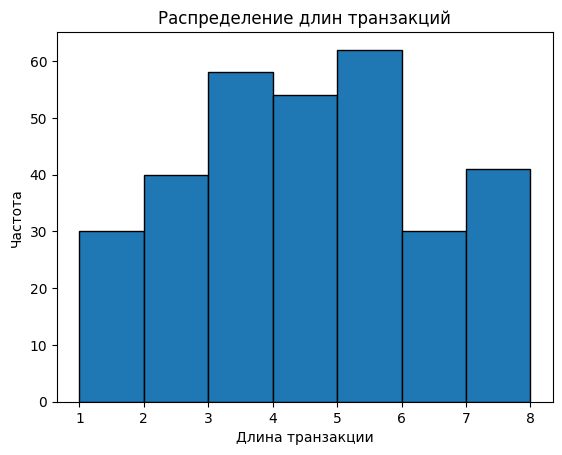

In [2]:
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2), edgecolor='black', linewidth=1.0)
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()


На графике распределения длин транзакций видно, как часто встречаются корзины разной длины. Транзакции, содержащие 1 или 6 товаров, встречаются примерно 30 раз, корзины из 2 и 7 товаров - около 40 раз. Примерно 55 раз наблюдаются покупки из 4 позиций, а транзакции с 3 товарами встречаются около 58 раз. Наиболее распространены корзины из 5 товаров - их число достигает приблизительно 62.

### Список уникальных значений

Выведем уникальные значения (товары):

In [3]:
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[0:] if isinstance(elem,str)] for row in np_data]
# np_data
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(unique_items)


{'Diaper', 'Bread', 'Milk', 'Meat', 'Pencil', 'Eggs', 'Wine', 'Cheese', 'Bagel'}


Мы получили множество уникальных товаров, присутствующих в транзакциях. В него входят: хлеб, мясо, вино, бублик, подгузники, молоко, сыр, яйца и карандаш. Это полный список позиций, встречающихся в датасете.

## 3. Ход работы

Выполним преобразование данных:

In [4]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)
data


,Bagel,Bread,Cheese,Diaper,Eggs,Meat,Milk,Pencil,Wine
0,False,True,True,True,True,True,False,True,True
1,False,True,True,True,False,True,True,True,True
2,False,False,True,False,True,True,True,False,True
3,False,False,True,False,True,True,True,False,True
4,False,False,False,False,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...
310,False,True,True,False,True,False,False,False,False
311,False,False,False,False,False,True,True,True,False
312,False,True,True,True,True,True,False,True,True
313,False,False,True,False,False,True,False,False,False


Мы преобразовали данные в бинарный формат, чтобы подготовить их к работе алгоритмов ассоциативных правил. В таком представлении нам не важно, сколько раз товар встречается в корзине - значение имеет только факт его наличия.

Например, в первой транзакции из всего набора уникальных товаров присутствуют хлеб, сыр, подгузники, яйца, мясо, карандаш и вино. Отсутствуют же бублик и молоко. Такое представление позволяет алгоритмам корректно анализировать состав корзин и выделять частые сочетания товаров.

### 3.1 Алгоритм Apriori

#### Анализ ассоциативных правил с изначальными условиями

Для начала рассмотрим ассоциативные правила, полученные при начальных параметрах алгоритма:
- Поддержка - 0.15;
- Достоверность - 0.4.

In [5]:
df1 = apriori(data, min_support=0.15, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.4)
# print(rules[["antecedents", "consequents", "support", "confidence", "lift"]])
print(f"Количество правил: {len(rules)}")
print(rules[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))


     support                    itemsets
0   0.425397                     (Bagel)
1   0.504762                     (Bread)
2   0.501587                    (Cheese)
3   0.406349                    (Diaper)
4   0.438095                      (Eggs)
5   0.476190                      (Meat)
6   0.501587                      (Milk)
7   0.361905                    (Pencil)
8   0.438095                      (Wine)
9   0.279365              (Bagel, Bread)
10  0.193651             (Bagel, Cheese)
11  0.184127             (Diaper, Bagel)
12  0.152381               (Eggs, Bagel)
13  0.190476               (Meat, Bagel)
14  0.225397               (Milk, Bagel)
15  0.158730             (Bagel, Pencil)
16  0.171429               (Bagel, Wine)
17  0.238095             (Bread, Cheese)
18  0.231746             (Diaper, Bread)
19  0.187302               (Eggs, Bread)
20  0.206349               (Meat, Bread)
21  0.279365               (Milk, Bread)
22  0.200000             (Bread, Pencil)
23  0.244444    

При исходных параметрах алгоритм Apriori (поддержка 0.15 и достоверность 0.4) было получено 99 ассоциативных правил, что указывает на высокую связанность товаров в датасете. Такой объём требует дальнейшего фильтрования, поэтому для последующего анализа целесообразно повышать пороги метрик, чтобы оставить только наиболее значимые зависимости.

Часть правил, например **Bagel → Bread**, **Bread → Bagel**, **Bagel → Diaper** или **Milk → Bagel**, можно отнести к тривиальным: они возникают из-за высокой частоты этих товаров в целом, поэтому даже при высоком уровне достоверности их аналитическая ценность ограничена - лифт в таких правилах близок к единице.

Более информативными являются правила с выраженной зависимостью между продуктами:

- Например, связь **Eggs → Cheese (confidence 0.681159, lift 1.358008)** и **Meat → Cheese (confidence 0.680000, lift 1.355696)** говорит о том, что сыр заметно чаще встречается в корзинах, содержащих яйца или мясо.

- Аналогично, правило **Cheese → Milk (confidence 0.607595, lift 1.211344)** демонстрирует умеренную, но объяснимую взаимосвязь между товарами.

- Правило **Wine → Cheese (confidence 0.615942, lift 1.227986)** выглядит логичным с потребительской точки зрения, поскольку сыр часто выступает закуской к вину.

- Интерес вызывает и зависимость **Diaper → Wine (confidence 0.578125, lift 1.319633)**, напоминающая классический пример «подгузники → пиво», что может отражать поведенческую специфику покупателей.

- Особо сильные зависимости наблюдаются в правилах с участием нескольких товаров, например **Eggs, Meat → Cheese (confidence 0.809524, lift 1.613924)** и **Milk, Meat → Cheese, Eggs (confidence 0.623377, lift 2.088975)**, где лифт превышает значения 1.5-2.0. Эти комбинации указывают на устойчивое совместное потребление ряда продуктов.

- Необычное, но статистически значимое правило **Pencil → Wine (confidence 0.552632, lift 1.261442)** также заслуживает внимания: несмотря на отсутствие очевидной логической связи, показатели метрик говорят об устойчивой совместной встречаемости данных товаров (возможно, люди покупают вино вместе с карандашами - например, чтобы работать или что-то рисовать «под бокал вина»).

#### Изменение параметров алгоритма

Увеличим значение поддержки до 20%, достоверности до 50%:

In [6]:
df1 = apriori(data, min_support=0.2, use_colnames = True)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.5)
# print(rules[["antecedents", "consequents", "support", "confidence", "lift"]])
print(f"Количество правил: {len(rules)}")
print(rules[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))


Количество правил: 35
   antecedents consequents  support  confidence     lift
       (Bagel)     (Bread) 0.279365    0.656716 1.301042
       (Bread)     (Bagel) 0.279365    0.553459 1.301042
       (Bagel)      (Milk) 0.225397    0.529851 1.056348
      (Diaper)     (Bread) 0.231746    0.570312 1.129864
        (Milk)     (Bread) 0.279365    0.556962 1.103415
       (Bread)      (Milk) 0.279365    0.553459 1.103415
      (Pencil)     (Bread) 0.200000    0.552632 1.094836
        (Wine)     (Bread) 0.244444    0.557971 1.105414
        (Eggs)    (Cheese) 0.298413    0.681159 1.358008
      (Cheese)      (Eggs) 0.298413    0.594937 1.358008
        (Meat)    (Cheese) 0.323810    0.680000 1.355696
      (Cheese)      (Meat) 0.323810    0.645570 1.355696
        (Milk)    (Cheese) 0.304762    0.607595 1.211344
      (Cheese)      (Milk) 0.304762    0.607595 1.211344
      (Pencil)    (Cheese) 0.200000    0.552632 1.101765
        (Wine)    (Cheese) 0.269841    0.615942 1.227986
      (Ch

После изменения параметров алгоритма Apriori также наблюдается закономерное влияние на результаты. При увеличении минимальной поддержки с 0.15 до 0.2 и порога достоверности с 0.4 до 0.5 количество ассоциативных правил сократилось с 99 до 35. Это объясняется тем, что более высокие пороги отсеивают редкие и малонадежные зависимости, оставляя только те правила, которые действительно устойчиво встречаются в большинстве транзакций. Средние значения confidence и lift при этом увеличились, что говорит о повышении общего качества выявленных связей.

Среди оставшихся правил чётко выделяются сильные зависимости между товарами, используемыми совместно:

- Например, правила **Eggs → Cheese (confidence 0.68, lift 1.36)** и **Meat → Cheese (confidence 0.68, lift 1.35)** демонстрируют стабильную взаимосвязь: при покупке яиц или мяса вероятность появления сыра в корзине заметно выше среднего.

- Ещё более сильная зависимость наблюдается в правилах с несколькими товарами, например **(Eggs, Meat) → Cheese (confidence 0.81, lift 1.61)** или **(Meat, Milk) → Cheese (confidence 0.83, lift 1.65)**, что отражает логичную совместную покупку ингредиентов для блюд.

В то же время часть правил остаётся тривиальной:

- Например, **Bread ↔ Bagel**, **Bread ↔ Milk** или **Bagel → Milk** имеют лифт около 1.05-1.30 и отражают скорее общую популярность этих товаров, чем их реальную взаимную зависимость. Такие правила трудно считать полезными, несмотря на формально высокие значения достоверности.

- Тем не менее среди оставшихся зависимостей встречаются и любопытные, но менее очевидные, такие как **Pencil → Wine (confidence 0.55, lift 1.26)**, что говорит о стабильной совместной встречаемости, хотя логическое объяснение подобной комбинации требует дополнительного контекста.

Таким образом, повышение минимальной поддержки и достоверности уменьшило количество найденных правил, но повысило их значимость и интерпретируемость. Итоговый набор стал компактнее и чище: в нём остались в основном сильные и логичные связи между товарами. Однако часть потенциально интересных зависимостей могла быть отфильтрована, поэтому для дальнейшего уточнения результатов целесообразно увеличить только порог достоверности (например, до 0.6), оставив минимальную поддержку на текущем уровне - это позволит выделить действительно сильные и информативные правила, не ограничиваясь лишь товарами-лидерами продаж.

Увеличим значение достоверности до 60%, значение поддержки оставим на уровне 20%:

In [7]:
df1 = apriori(data, min_support=0.2, use_colnames = True)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.6)
# print(rules[["antecedents", "consequents", "support", "confidence", "lift"]])
print(f"Количество правил: {len(rules)}")
print(rules[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))

Количество правил: 14
   antecedents consequents  support  confidence     lift
       (Bagel)     (Bread) 0.279365    0.656716 1.301042
        (Eggs)    (Cheese) 0.298413    0.681159 1.358008
        (Meat)    (Cheese) 0.323810    0.680000 1.355696
      (Cheese)      (Meat) 0.323810    0.645570 1.355696
        (Milk)    (Cheese) 0.304762    0.607595 1.211344
      (Cheese)      (Milk) 0.304762    0.607595 1.211344
        (Wine)    (Cheese) 0.269841    0.615942 1.227986
        (Eggs)      (Meat) 0.266667    0.608696 1.278261
  (Eggs, Meat)    (Cheese) 0.215873    0.809524 1.613924
(Eggs, Cheese)      (Meat) 0.215873    0.723404 1.519149
(Meat, Cheese)      (Eggs) 0.215873    0.666667 1.521739
  (Milk, Meat)    (Cheese) 0.203175    0.831169 1.657077
(Milk, Cheese)      (Meat) 0.203175    0.666667 1.400000
(Meat, Cheese)      (Milk) 0.203175    0.627451 1.250931


После повышения порога достоверности до 0.6 (при поддержке 0.2) количество правил сократилось с 35 до 14. В выборке остались только самые надёжные зависимости с высоким confidence и устойчивым лифтом:

- Почти все правила связаны с группой продуктов **Cheese**, **Eggs**, **Meat** и **Milk**, которые чаще всего встречаются вместе.

- Наиболее сильные связи - **(Eggs, Meat) → Cheese** и **(Meat, Milk) → Cheese**, где достоверность превышает 0.8, а лифт достигает 1.6.

- Тривиальные правила практически исчезли, и финальный набор содержит только действительно значимые и логичные ассоциации.

Увеличим значение достоверности до 70%:

In [8]:
df1 = apriori(data, min_support=0.2, use_colnames = True)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.7)
# print(rules[["antecedents", "consequents", "support", "confidence", "lift"]])
print(f"Количество правил: {len(rules)}")
print(rules[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))

Количество правил: 3
   antecedents consequents  support  confidence     lift
  (Eggs, Meat)    (Cheese) 0.215873    0.809524 1.613924
(Eggs, Cheese)      (Meat) 0.215873    0.723404 1.519149
  (Milk, Meat)    (Cheese) 0.203175    0.831169 1.657077


После увеличения порога достоверности до 0.7 в выборке осталось всего 3 правила:

- Два из них образуют взаимосвязанную пару: **(Cheese, Eggs) → Meat** и **(Eggs, Meat) → Cheese**, что отражает сильную трёхстороннюю зависимость между яйцами, сыром и мясом.

- Третье правило - **(Meat, Milk) → Cheese** - также сохраняет высокие значения метрик и подтверждает устойчивую совместную покупку этих продуктов. 

Однако при столь строгих параметрах большинство более интересных и разнообразных комбинаций исчезает, поэтому имеет смысл снова снизить порог поддержки до 0.15, чтобы получить более широкий набор правил для анализа.

In [9]:
df1 = apriori(data, min_support=0.15, use_colnames = True)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.7)
# print(rules[["antecedents", "consequents", "support", "confidence", "lift"]])
print(f"Количество правил: {len(rules)}")
print(rules[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))

Количество правил: 12
         antecedents consequents  support  confidence     lift
       (Milk, Bagel)     (Bread) 0.171429    0.760563 1.506777
        (Eggs, Meat)    (Cheese) 0.215873    0.809524 1.613924
      (Eggs, Cheese)      (Meat) 0.215873    0.723404 1.519149
        (Eggs, Milk)    (Cheese) 0.196825    0.805195 1.605293
        (Milk, Meat)    (Cheese) 0.203175    0.831169 1.657077
        (Milk, Wine)    (Cheese) 0.161905    0.739130 1.473583
        (Eggs, Milk)      (Meat) 0.177778    0.727273 1.527273
        (Milk, Meat)      (Eggs) 0.177778    0.727273 1.660079
  (Eggs, Milk, Meat)    (Cheese) 0.152381    0.857143 1.708861
(Eggs, Milk, Cheese)      (Meat) 0.152381    0.774194 1.625806
(Eggs, Meat, Cheese)      (Milk) 0.152381    0.705882 1.407297
(Milk, Meat, Cheese)      (Eggs) 0.152381    0.750000 1.711957


После увеличения порога достоверности до 0.7 при минимальной поддержке 0.15 количество правил составило 12. В наборе остались только самые устойчивые зависимости, которые встречаются в данных наиболее последовательно. Средние значения confidence и lift заметно выросли, что указывает на более сильные и надёжные связи между товарами по сравнению с предыдущими параметрами.

Самые выраженные закономерности снова формируются вокруг группы продуктов **Cheese**, **Eggs**, **Meat** и **Milk**:

- Например, правило **(Eggs, Meat, Milk) → Cheese** имеет достоверность 0.857143 и лифт 1.708861 - это самая сильная зависимость среди всех найденных, подтверждающая, что покупка этих товаров почти всегда сопровождается приобретением сыра.

- Аналогично, правила **(Meat, Milk) → Eggs** и **(Eggs, Milk) → Meat** обладают высоким confidence (≈0.73) и значительным лифтом (до 1.66–1.71), что отражает устойчивые взаимные связи внутри этой группы продуктов.

Также в наборе появилось правило **(Bagel, Milk) → Bread** с высокими показателями уверенности (0.76) и усилением связи (1.50), что подтверждает популярность хлеба в сочетании с этими товарами. В целом, такие результаты показывают, что при пороге 0.7 алгоритм выделяет только самые надёжные и логичные ассоциации, которые действительно отражают реальное поведение покупателей.

Таким образом, ужесточение параметров уменьшает разнообразие правил, но значительно повышает их значимость и интерпретируемость. В результирующем наборе остаются только сильные и закономерные связи, что делает анализ более точным и полезным.

#### Топ-10 популярных продуктов

Отобразим топ-10 самых популярных продуктов:

     support      itemsets
1   0.504762         Bread
2   0.501587        Cheese
6   0.501587          Milk
5   0.476190          Meat
8   0.438095          Wine
4   0.438095          Eggs
0   0.425397         Bagel
3   0.406349        Diaper
7   0.361905        Pencil
26  0.323810  Meat, Cheese


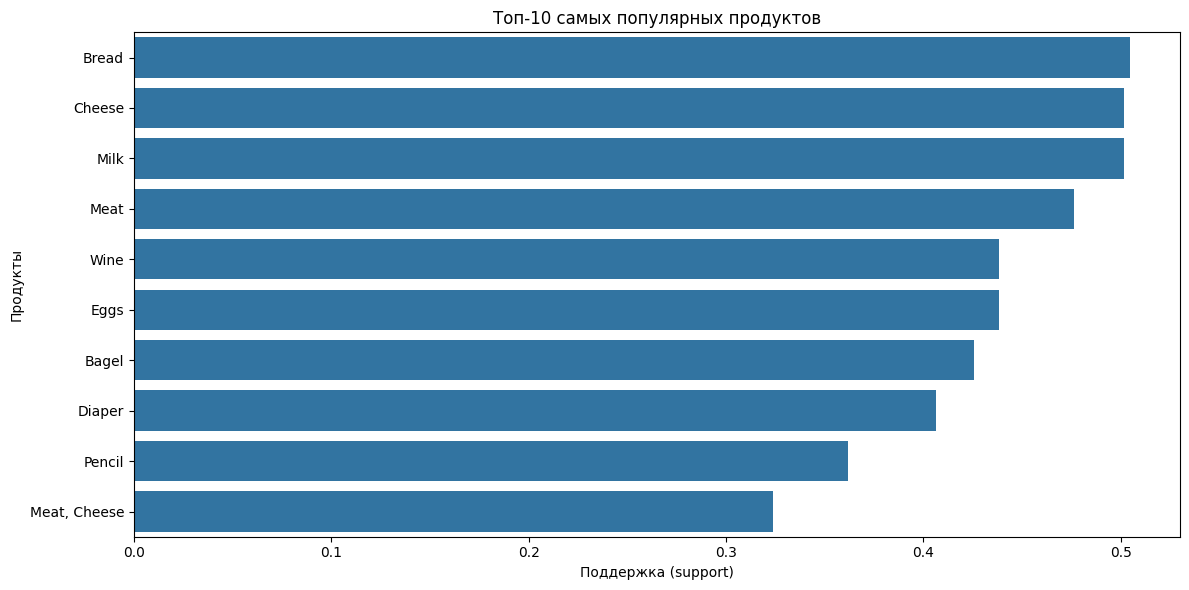

In [10]:
df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(10)

print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка (support)')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()


На представленном списке показаны товары с наибольшей поддержкой - то есть те, что встречаются в транзакциях чаще всего. Абсолютными лидерами являются **хлеб**, **сыр** и **молоко** - их поддержка находится на уровне около 0.5, значит, они присутствуют более чем в половине всех покупок. За ними следуют **мясо**, **вино** и **яйца**, которые также встречаются регулярно, но немного уступают основным товарам-лидерам.

Товары **бублик** и **подгузники** занимают средние позиции - это говорит о стабильном, но менее массовом спросе. **Карандаш** встречается реже остальных, однако всё ещё входит в десятку популярных позиций. Замыкает рейтинг пара **«сыр и мясо»** - она отражает частое совместное появление этих продуктов и может объясняться их использованием вместе при приготовлении блюд.

#### График достоверности и граф ассоциативных правил

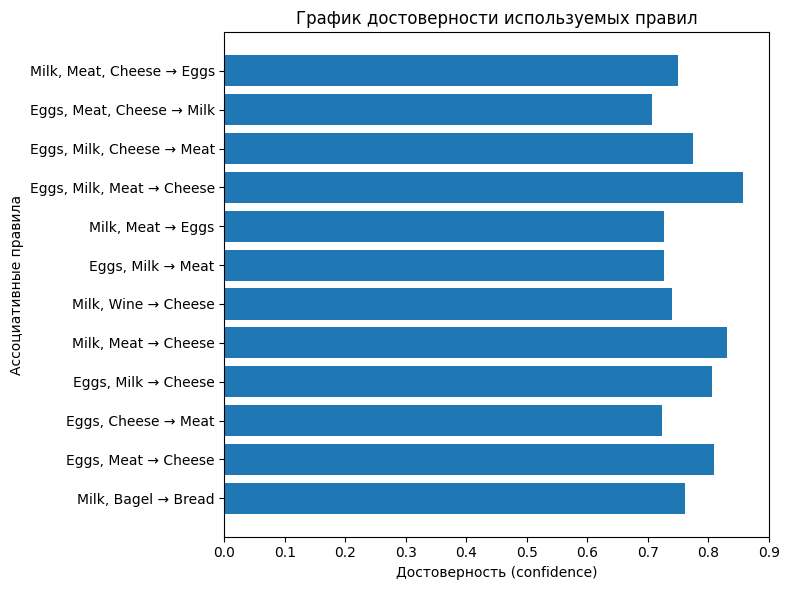

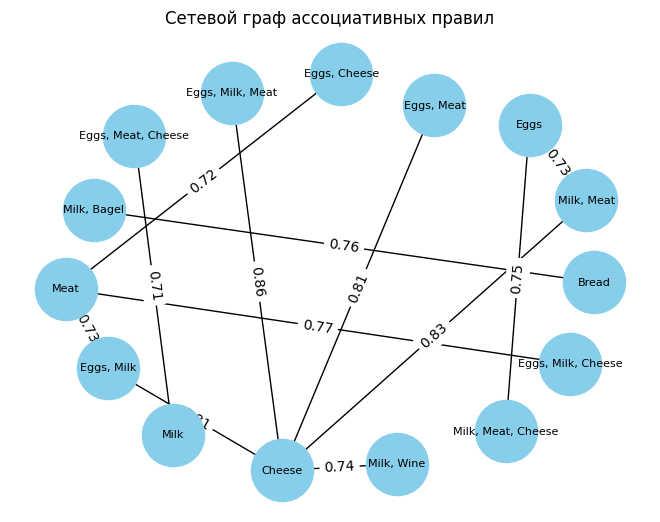

In [11]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} → {product2}" for product1, product2 in zip(products_1, products_2)]

plt.figure(figsize=(8, 6))
plt.barh(rules_labels, confidence)
plt.xlabel("Достоверность (confidence)")
plt.ylabel("Ассоциативные правила")
plt.title("График достоверности используемых правил")
plt.tight_layout()
plt.show()

# Сетевой граф
G = nx.Graph()
for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=round(row['confidence'], 2))

pos = nx.spring_layout(G, k=8, iterations=100)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Сетевой граф ассоциативных правил')
# plt.tight_layout()
plt.show()


График демонстрирует значения достоверности для обнаруженных ассоциативных правил. Все правила имеют высокие показатели confidence - от 0.7 до 0.85, что говорит о сильной вероятности совместного появления товаров. Самое надёжное правило связано с сочетанием **яиц**, **молока** и **мяса**, приводящим к покупке **сыра** - вероятность того, что сыр окажется в корзине вместе с этими продуктами, превышает 85%.

Хорошо заметно, что основные продукты питания - **молоко**, **мясо**, **яйца**, **сыр** и **хлеб** - формируют наиболее устойчивые и логичные связи. Это отражает естественные покупательские привычки, когда покупатели приобретают базовые продукты совместно. Менее высокие значения достоверности (около 0.7) характерны для менее очевидных сочетаний, например **«молоко и бублик → хлеб»**, однако даже такие связи остаются статистически значимыми.

Структура графа ассоциативных правил показывает, что центральным элементом сети является **сыр** - он образует наибольшее число связей с другими продуктами. Особенно сильные ассоциации наблюдаются между **сыром**, **молоком** и **мясом**, что указывает на частые совместные покупки. Значимые связи прослеживаются также между **сыром**, **хлебом**, **яйцами** и их комбинациями.

Кроме того, устойчивые связи наблюдаются между **мясом**, **яйцами** и **молоком** - эти группы товаров типично появляются вместе в продуктовых корзинах, связанных с приготовлением блюд. В целом структура графа показывает, что **сыр** объединяет вокруг себя плотный кластер ключевых продуктов, которые регулярно встречаются совместно в транзакциях.

#### Минимальные значения поддержки для составления правил из 1, 2 и т. д. объектов:

Минимальные значения поддержки по длинам наборов:
length
1    0.361905
2    0.152381
3    0.063492
4    0.050794
5    0.050794
Name: support, dtype: float64


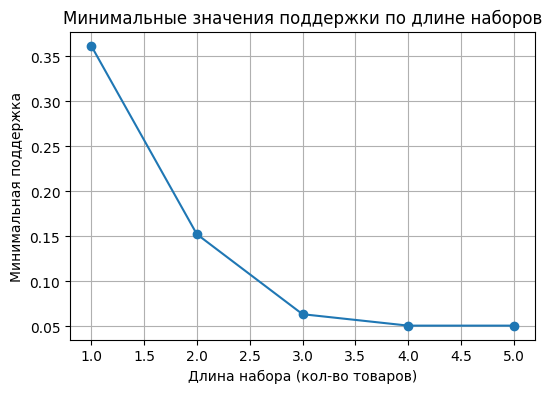

In [12]:
df1 = apriori(data, min_support=0.05, use_colnames = True)
df1['length'] = df1['itemsets'].apply(lambda x: len(x))

min_support_by_len = df1.groupby('length')['support'].min()

print("Минимальные значения поддержки по длинам наборов:")
print(min_support_by_len)

plt.figure(figsize=(6,4))
plt.plot(min_support_by_len.index, min_support_by_len.values, marker='o')
plt.xlabel('Длина набора (кол-во товаров)')
plt.ylabel('Минимальная поддержка')
plt.title('Минимальные значения поддержки по длине наборов')
plt.grid(True)
plt.show()


Можно заметить, что для наборов из двух товаров минимальная поддержка составляет около 15%, тогда как для более длинных наборов она резко падает. Это объясняется тем, что транзакций, содержащих сразу 3 и более товаров из одного правила, значительно меньше. Для сочетаний из трёх товаров минимальная поддержка опускается до 6%, а для наборов из четырёх и пяти товаров - примерно до 5%, что отражает их редкую встречаемость в датасете.

#### Визуализация ассоциативных правил и метрик

В качестве собственного подхода к визуализации ассоциативных правил можно использовать тепловую карту, отражающую значения достоверности:

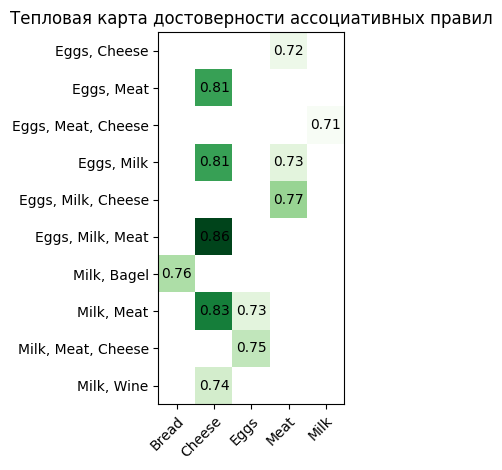

In [13]:
import numpy as np

rules_plot = pd.DataFrame()
rules_plot['antecedents']= rules['antecedents']
rules_plot['consequents']= rules['consequents']
rules_plot['confidence']= rules['confidence'].apply(lambda x: round(x, 2))

pivot = rules_plot.pivot(index = 'antecedents', columns = 'consequents', values= 'confidence')
antecedents = list(pivot.index.values)
consequents = list(pivot.columns)
pivot = pivot.to_numpy()

fig, ax = plt.subplots()
im = ax.imshow(pivot, cmap = 'Greens')
ax.set_xticks(np.arange(len(consequents)))
ax.set_yticks(np.arange(len(antecedents)))
ax.set_xticklabels(consequents)
ax.set_yticklabels(antecedents)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(antecedents)):
    for j in range(len(consequents)):
        if not np.isnan(pivot[i, j]):
            text = ax.text(j, i, pivot[i, j], ha="center", va="center")
ax.set_title("Тепловая карта достоверности ассоциативных правил")
fig.tight_layout()
plt.show()

Тепловая карта позволяет наглядно увидеть, какие ассоциативные правила обладают наибольшими значениями лифта - чем темнее оттенок ячейки, тем сильнее связь между товарами. По визуализации хорошо видно, что наборы, включающие **яйца**, **мясо** и **молоко**, почти всегда приводят к добавлению **сыра** в корзину. Аналогично, сочетание **мяса** и **молока** с высокой вероятностью также связано с покупкой **сыра**.

Более светлые ячейки, такие как правило **Cheese, Eggs, Meat → Milk** с достоверностью около 0.71, указывают на менее выраженную, но всё же заметную взаимосвязь между товарами.

Средние значения confidence (примерно 0.71-0.77) характерны для правил, содержащих комбинации **Cheese**, **Eggs**, **Meat** и **Milk**, что ещё раз подчёркивает логичную взаимодополняемость основных продуктов питания и их частое совместное появление в транзакциях.

### 3.2 Алгоритм FPG

#### Анализ ассоциативных правил с изначальными условиями

Для начала рассмотрим ассоциативные правила, полученные при начальных параметрах алгоритма:
- Поддержка - 0.15;
- Достоверность - 0.4.

In [14]:
df2 = fpgrowth(data, min_support=0.15, use_colnames = True)
print(df2)
rules_fpg = association_rules(df2, metric = "confidence", min_threshold = 0.4)
print(f"Количество правил: {len(rules_fpg)}")
print(rules_fpg[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))



     support                    itemsets
0   0.504762                     (Bread)
1   0.501587                    (Cheese)
2   0.476190                      (Meat)
3   0.438095                      (Wine)
4   0.438095                      (Eggs)
5   0.406349                    (Diaper)
6   0.361905                    (Pencil)
7   0.501587                      (Milk)
8   0.425397                     (Bagel)
9   0.238095             (Bread, Cheese)
10  0.323810              (Meat, Cheese)
11  0.206349               (Meat, Bread)
12  0.244444                (Milk, Meat)
13  0.203175        (Milk, Meat, Cheese)
14  0.269841              (Wine, Cheese)
15  0.250794                (Meat, Wine)
16  0.244444               (Wine, Bread)
17  0.219048                (Milk, Wine)
18  0.168254        (Meat, Wine, Cheese)
19  0.161905        (Milk, Wine, Cheese)
20  0.298413              (Eggs, Cheese)
21  0.266667                (Eggs, Meat)
22  0.241270                (Eggs, Wine)
23  0.187302    

По итогам работы алгоритма FPG было получено 99 ассоциативных правил - столько же, сколько и при использовании алгоритма Apriori. Это говорит о том, что оба метода выявили одинаковую структуру связей между товарами, а значит найденные закономерности устойчивы и не зависят от выбора алгоритма.

Среди правил присутствуют тривиальные зависимости, характерные для часто встречающихся товаров. К таким можно отнести, например, **Cheese → Bread (достоверность 0.474684, лифт 0.94)**, **Bread → Meat** или **Milk → Meat**. Эти правила основаны на популярных товарах, поэтому их аналитическая ценность невысока. Кроме того, правила с лифтом меньше 1 (например, **Cheese → Bread** или **Bagel → Cheese**) указывают на отсутствие реальной зависимости и могут быть отброшены.

Среди полезных и информативных правил можно выделить следующие:

- **Milk, Meat → Cheese (confidence 0.831169, lift 1.657077)** - одно из самых сильных правил, отражающее частое совместное использование этих продуктов.

- **Diaper → Wine (confidence 0.578125, lift 1.319633)** - интересная закономерность, ранее отмеченная и в Apriori.

- **Pencil → Diaper (confidence 0.473684, lift 1.165707)** - неочевидная, но статистически подтверждаемая связь. Возможное объяснение: покупатели приобретают карандаши для старших детей и одновременно подгузники для младших.

- **Eggs → Cheese (confidence 0.681159, lift 1.358008)** - логичное правило, отражающее совместное использование продуктов в кулинарии.

- **Wine → Cheese (confidence 0.615942, lift 1.227986)** - популярная и объяснимая комбинация.

- **Wine → Meat (confidence 0.572464, lift 1.202174)** - также логичная ассоциация, например, для приготовления ужина.

В итоге алгоритм FPG выявил тот же набор ключевых связей, что и Apriori, при этом подтвердив устойчивость наиболее значимых правил и наличие как очевидных, так и неожиданных, но объяснимых зависимостей.

#### Изменение параметров алгоритма

Увеличим значение поддержки до 20%, достоверности до 50%:

In [15]:
df2 = fpgrowth(data, min_support=0.2, use_colnames = True)
rules_fpg = association_rules(df2, metric = "confidence", min_threshold = 0.5)
print(f"Количество правил: {len(rules_fpg)}")
print(rules_fpg[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))


Количество правил: 35
   antecedents consequents  support  confidence     lift
        (Meat)    (Cheese) 0.323810    0.680000 1.355696
      (Cheese)      (Meat) 0.323810    0.645570 1.355696
        (Meat)      (Milk) 0.244444    0.513333 1.023418
  (Milk, Meat)    (Cheese) 0.203175    0.831169 1.657077
(Milk, Cheese)      (Meat) 0.203175    0.666667 1.400000
(Meat, Cheese)      (Milk) 0.203175    0.627451 1.250931
        (Wine)    (Cheese) 0.269841    0.615942 1.227986
      (Cheese)      (Wine) 0.269841    0.537975 1.227986
        (Meat)      (Wine) 0.250794    0.526667 1.202174
        (Wine)      (Meat) 0.250794    0.572464 1.202174
        (Wine)     (Bread) 0.244444    0.557971 1.105414
        (Wine)      (Milk) 0.219048    0.500000 0.996835
        (Eggs)    (Cheese) 0.298413    0.681159 1.358008
      (Cheese)      (Eggs) 0.298413    0.594937 1.358008
        (Eggs)      (Meat) 0.266667    0.608696 1.278261
        (Meat)      (Eggs) 0.266667    0.560000 1.278261
        (

После применения параметров алгоритма Apriori с минимальной поддержкой 0.2 и достоверностью 0.5 общее количество найденных правил составило 35. Такое число закономерностей ожидаемо при выбранных порогах - чем выше минимальные значения метрик, тем меньше комбинаций товаров проходят фильтрацию, поскольку учитываются только устойчивые и достаточно частотные зависимости.

Даже при относительно небольшом количестве правил среди них сохранились наиболее значимые связи. Особенно выделяются такие закономерности, как:

- **Meat → Cheese** с достоверностью 0.68 и лифтом 1.35.

- **Meat, Milk → Cheese** с достоверностью 0.83 и лифтом 1.65.

- **Cheese → Meat** с достоверностью 0.64 и лифтом 1.35.

Эти зависимости показывают выраженную взаимосвязь между товарами и заметное увеличение вероятности совместной покупки по сравнению со случайным совпадением.

Хорошо прослеживается группа устойчивых связей с участием **Eggs**, например **Eggs → Cheese (0.68, lift=1.35)** и **Eggs → Meat (0.60, lift=1.27)**. Аналогично сохраняются закономерности для напитков и хлебобулочных изделий, включая **Diaper → Wine (0.58, lift=1.32)**, что традиционно демонстрирует поведенческие паттерны покупателей. Эти правила можно считать наиболее информативными и значимыми, поскольку они обладают высоким лифтом и отражают реальные покупательские комбинации.

Для дальнейшего анализа можно увеличить порог достоверности до 0.6, чтобы выделить только правила с наиболее сильной зависимостью между товарами. Поддержку при этом менять не требуется - ее повышение приведет к исключению правил с товарами средней популярности, что сделает оставшиеся зависимости слишком очевидными и менее полезными для анализа.

Увеличим значение достоверности до 60%, значение поддержки оставим на уровне 20%:

In [16]:
df2 = fpgrowth(data, min_support=0.2, use_colnames = True)
rules_fpg = association_rules(df2, metric = "confidence", min_threshold = 0.6)
print(f"Количество правил: {len(rules_fpg)}")
print(rules_fpg[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))


Количество правил: 14
   antecedents consequents  support  confidence     lift
        (Meat)    (Cheese) 0.323810    0.680000 1.355696
      (Cheese)      (Meat) 0.323810    0.645570 1.355696
  (Milk, Meat)    (Cheese) 0.203175    0.831169 1.657077
(Milk, Cheese)      (Meat) 0.203175    0.666667 1.400000
(Meat, Cheese)      (Milk) 0.203175    0.627451 1.250931
        (Wine)    (Cheese) 0.269841    0.615942 1.227986
        (Eggs)    (Cheese) 0.298413    0.681159 1.358008
        (Eggs)      (Meat) 0.266667    0.608696 1.278261
  (Eggs, Meat)    (Cheese) 0.215873    0.809524 1.613924
(Eggs, Cheese)      (Meat) 0.215873    0.723404 1.519149
(Meat, Cheese)      (Eggs) 0.215873    0.666667 1.521739
        (Milk)    (Cheese) 0.304762    0.607595 1.211344
      (Cheese)      (Milk) 0.304762    0.607595 1.211344
       (Bagel)     (Bread) 0.279365    0.656716 1.301042


После увеличения порога достоверности до 0.6 количество найденных правил сократилось с 35 до 14, что ожидаемо, поскольку фильтрация стала жёстче и в выборку попадают только наиболее устойчивые зависимости. Повышение минимальной достоверности приводит к тому, что остаются лишь те случаи, где появление одного товара значительно повышает вероятность появления другого.

Сохранившиеся правила демонстрируют высокое качество: все они имеют доверие выше 0.6 и лифт больше единицы, что указывает на положительную связь между товарами. Наиболее заметными остаются ассоциации между **Meat**, **Cheese**, **Milk** и **Eggs**. Например, правило **Meat, Milk → Cheese** имеет достоверность 0.83 и лифт 1.65, а **Meat, Eggs → Cheese** обладает достоверностью 0.81 и лифтом 1.61, что говорит о частом одновременном выборе этих товаров.

Сокращение количества правил показывает, что алгоритм начинает отсекать менее значимые и редкие закономерности, оставляя только действительно сильные связи. Поэтому при повышении порога достоверности уменьшается число ассоциаций, но возрастает их надёжность и аналитическая ценность. Однако при этом исчезли зависимости с товарами, встречающимися реже, например - **Diaper** или **Pencil**.

Увеличим значение достоверности до 70%:

In [17]:
df2 = fpgrowth(data, min_support=0.2, use_colnames = True)
rules_fpg = association_rules(df2, metric = "confidence", min_threshold = 0.7)
print(f"Количество правил: {len(rules_fpg)}")
print(rules_fpg[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))


Количество правил: 3
   antecedents consequents  support  confidence     lift
  (Milk, Meat)    (Cheese) 0.203175    0.831169 1.657077
  (Eggs, Meat)    (Cheese) 0.215873    0.809524 1.613924
(Eggs, Cheese)      (Meat) 0.215873    0.723404 1.519149


После повышения порога достоверности до 0.7 количество найденных правил сократилось до 3. Это полностью соответствует логике фильтрации: при таком значении остаются только самые сильные зависимости, которые проявляются практически всегда при совместной покупке товаров. Интересно, что набор правил совпадает с результатами алгоритма Apriori при тех же параметрах, что подтверждает устойчивость найденных закономерностей.

Все оставшиеся правила обладают высокой достоверностью (от 0.72 до 0.83) и значениями лифта существенно выше единицы, что указывает на сильную взаимосвязь между товарами. Например, правило **Meat, Milk → Cheese** имеет достоверность 0.83 и лифт 1.65, а **Meat, Eggs → Cheese** достигает доверия 0.81 и лифта 1.61, отражая устойчивый паттерн совместных покупок.

Чтобы получить более разнообразные и интересные правила, порог достоверности оставим таким же, а поддержку уменьшим до 15%:

In [18]:
df2 = fpgrowth(data, min_support=0.15, use_colnames = True)
rules_fpg = association_rules(df2, metric = "confidence", min_threshold = 0.7)
print(f"Количество правил: {len(rules_fpg)}")
print(rules_fpg[["antecedents","consequents","support","confidence","lift"]].to_string(index=False))


Количество правил: 12
         antecedents consequents  support  confidence     lift
        (Milk, Meat)    (Cheese) 0.203175    0.831169 1.657077
        (Milk, Wine)    (Cheese) 0.161905    0.739130 1.473583
        (Eggs, Meat)    (Cheese) 0.215873    0.809524 1.613924
      (Eggs, Cheese)      (Meat) 0.215873    0.723404 1.519149
        (Eggs, Milk)    (Cheese) 0.196825    0.805195 1.605293
        (Eggs, Milk)      (Meat) 0.177778    0.727273 1.527273
        (Milk, Meat)      (Eggs) 0.177778    0.727273 1.660079
  (Eggs, Milk, Meat)    (Cheese) 0.152381    0.857143 1.708861
(Eggs, Milk, Cheese)      (Meat) 0.152381    0.774194 1.625806
(Eggs, Meat, Cheese)      (Milk) 0.152381    0.705882 1.407297
(Milk, Meat, Cheese)      (Eggs) 0.152381    0.750000 1.711957
       (Milk, Bagel)     (Bread) 0.171429    0.760563 1.506777


При поддержке 0.15 и достоверности 0.7 алгоритм выделил 12 значимых правил, которые отражают устойчивые сочетания товаров в покупках. Наиболее сильные зависимости наблюдаются среди сочетаний **Meat**, **Milk**, **Eggs** и **Cheese**. Например, правило **Meat, Milk → Cheese** показывает достоверность 0.83 и лифт 1.66, что говорит о частом совместном выборе этих продуктов.

Интересным является и правило **Bagel, Milk → Bread** с достоверностью 0.76 и лифтом 1.50, которое характерно для покупок товаров, связанных с завтраком или перекусами.

При таких параметрах достигается сбалансированный результат: количество правил увеличивается, но при этом сохраняется высокая интерпретируемость и аналитическая ценность обнаруженных взаимосвязей между товарами.

#### График достоверности и граф ассоциативных правил

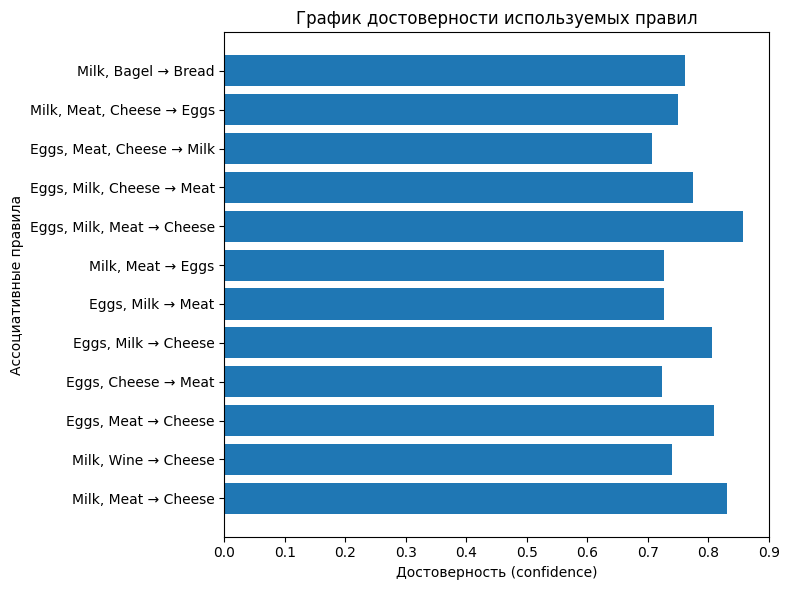

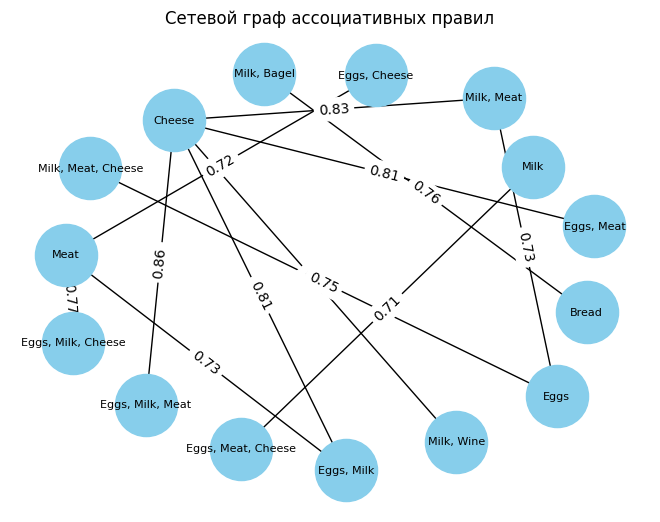

In [19]:
df2['itemsets'] = df2['itemsets'].apply(lambda x: ', '.join(list(x)))
rules_fpg['antecedents'] = rules_fpg['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_fpg['consequents'] = rules_fpg['consequents'].apply(lambda x: ', '.join(list(x)))
products_1 = rules_fpg["antecedents"].tolist()
products_2 = rules_fpg["consequents"].tolist()
confidence = rules_fpg["confidence"].tolist()
rules_labels = [f"{product1} → {product2}" for product1, product2 in zip(products_1, products_2)]

plt.figure(figsize=(8, 6))
plt.barh(rules_labels, confidence)
plt.xlabel("Достоверность (confidence)")
plt.ylabel("Ассоциативные правила")
plt.title("График достоверности используемых правил")
plt.tight_layout()
plt.show()


G = nx.Graph()
for product in rules_fpg["antecedents"]:
    G.add_node(product)
for product in rules_fpg["consequents"]:
    G.add_node(product)
for index, row in rules_fpg.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=round(row['confidence'],2))

pos = nx.spring_layout(G, k=8, iterations=100)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Сетевой граф ассоциативных правил')
# plt.tight_layout()
plt.show()


График достоверности для алгоритма FPG отражает распределение доверия среди найденных ассоциативных правил. Поскольку полученные результаты совпадают с теми, что дал алгоритм Apriori, можно заключить, что оба метода выделили одни и те же зависимости, что подтверждает стабильность и корректность выявленных закономерностей.

На графике видно, что большая часть правил имеет доверие выше 0.7, что говорит о высокой вероятности совместного появления соответствующих товаров. Самые выраженные зависимости наблюдаются для правил **Eggs, Meat, Milk → Cheese** и **Meat, Milk → Cheese**, где уровень доверия превышает 0.8, указывая на частое совместное присутствие этих продуктов в транзакциях.

Немного более низкие значения доверия (в пределах 0.7-0.75) характерны для правил с участием **Wine**, **Bagel** или **Eggs**, что свидетельствует о менее выраженных, но всё же заметных связях.

На графе ассоциаций центральное положение также занимает **Cheese**. Этот товар имеет наибольшее число связей с остальными продуктами, что подчёркивает его важную роль в формировании частых наборов. Особенно сильные связи наблюдаются между **сыром**, **мясом** и **молоком**, так как эти товары часто появляются в одних и тех же покупках.

**Сыр** также образует устойчивые пары с **хлебом**, **яйцами** и различными их сочетаниями, что отражает типичные паттерны покупательского поведения. Между **мясом**, **яйцами** и **молоком** также сформировались значимые зависимости, подтверждающие наличие характерных наборов товаров.

Таким образом, графики демонстрируют, что алгоритм FPG выявляет ключевые и повторяющиеся связи между товарами так же эффективно, как и Apriori, обеспечивая аналогичное качество правил при более высокой скорости обработки данных.

#### Минимальные значения поддержки для составления правил из 1, 2 и т. д. объектов:

Минимальные значения поддержки по длинам наборов:
length
1    0.361905
2    0.152381
3    0.063492
4    0.050794
5    0.050794
Name: support, dtype: float64


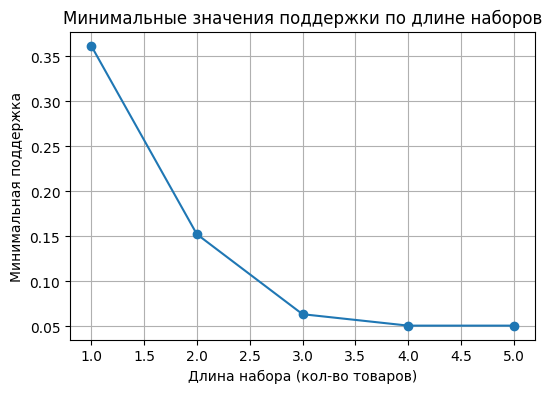

In [20]:
df1 = apriori(data, min_support=0.05, use_colnames = True)
df1['length'] = df1['itemsets'].apply(lambda x: len(x))

min_support_by_len = df1.groupby('length')['support'].min()

print("Минимальные значения поддержки по длинам наборов:")
print(min_support_by_len)

plt.figure(figsize=(6,4))
plt.plot(min_support_by_len.index, min_support_by_len.values, marker='o')
plt.xlabel('Длина набора (кол-во товаров)')
plt.ylabel('Минимальная поддержка')
plt.title('Минимальные значения поддержки по длине наборов')
plt.grid(True)
plt.show()


Можно заметить, что для правил, включающих только 2 товара, минимальная поддержка держится на уровне около 15%. Однако при увеличении размера набора товаров поддержка снижается, поскольку транзакций, содержащих сразу 3 и более элементов правила, значительно меньше по сравнению с общим числом покупок. Для наборов из 3 товаров поддержка опускается примерно до 6%, а для комбинаций из 4-5 товаров она немного ниже и составляет около 5%.

#### Визуализация ассоциативных правил и метрик

В качестве собственного подхода к визуализации ассоциативных правил можно использовать тепловую карту, отражающую значения достоверности:

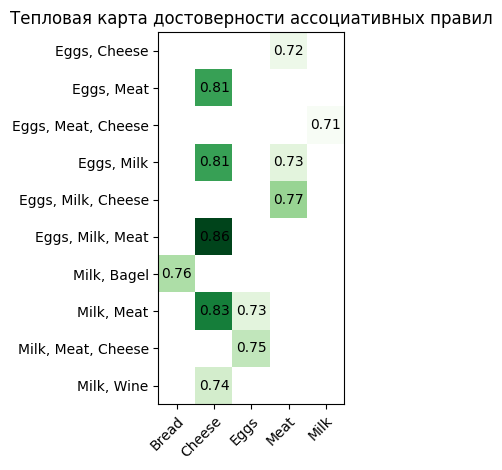

In [21]:
import numpy as np

rules_plot = pd.DataFrame()
rules_plot['antecedents']= rules['antecedents']
rules_plot['consequents']= rules['consequents']
rules_plot['confidence']= rules['confidence'].apply(lambda x: round(x, 2))

pivot = rules_plot.pivot(index = 'antecedents', columns = 'consequents', values= 'confidence')
antecedents = list(pivot.index.values)
consequents = list(pivot.columns)
pivot = pivot.to_numpy()

fig, ax = plt.subplots()
im = ax.imshow(pivot, cmap = 'Greens')
ax.set_xticks(np.arange(len(consequents)))
ax.set_yticks(np.arange(len(antecedents)))
ax.set_xticklabels(consequents)
ax.set_yticklabels(antecedents)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(antecedents)):
    for j in range(len(consequents)):
        if not np.isnan(pivot[i, j]):
            text = ax.text(j, i, pivot[i, j], ha="center", va="center")
ax.set_title("Тепловая карта достоверности ассоциативных правил")
fig.tight_layout()
plt.show()

На тепловой карте достоверности ассоциативных правил отражена интенсивность связей между различными наборами товаров. Чем насыщеннее зелёный цвет, тем выше достоверность и тем надёжнее правило, связывающее соответствующие продукты.

Самые выраженные области сосредоточены в столбце, соответствующем **Cheese**, что подчёркивает его ключевую роль - именно с ним связаны наибольшие значения достоверности. Особенно высокие показатели наблюдаются для комбинаций **Eggs, Meat, Milk с сыром (0.86)**, а также **Meat, Milk с сыром (0.83)**. Другие сочетания, например **Eggs, Meat (0.81)** или **Cheese, Eggs, Milk (0.77)**, также демонстрируют заметно высокие значения, что говорит о стабильной взаимосвязи этих товаров.

Таким образом, тепловая карта ещё раз показывает, что сыр выступает центральным элементом частых наборов, а его комбинации с мясом, молоком и яйцами являются наиболее значимыми. Полученные результаты совпадают с выводами алгоритма Apriori, что подтверждает устойчивость и надёжность выявленных ассоциативных зависимостей.

## 4. Заключение

В ходе выполнения работы был проведён анализ ассоциативных правил с использованием алгоритмов Apriori и FP-Growth. Были протестированы разные значения поддержки и достоверности, что позволило определить оптимальные параметры - поддержка 0.15 и достоверность 0.7. При таких настройках удалось получить умеренное число правил с высокими значениями доверия и лифта, что свидетельствует о надёжных связях между товарами.

Наиболее выраженными оказались зависимости между молоком, мясом, яйцами и сыром - такие сочетания часто встречаются в реальных транзакциях. Повышение пороговых значений показало ожидаемый эффект - число правил уменьшалось, но их качество и интерпретируемость становились выше.

Оба алгоритма - Apriori и FP-Growth - дали одинаковые результаты, поскольку опираются на общую идею поиска частых наборов, различаясь лишь механизмом генерации кандидатов. Apriori последовательно расширяет множества, а FP-Growth использует дерево частых шаблонов для ускорения вычислений. Совпадение итогов подтверждает корректность работы методов и достоверность выявленных зависимостей.

Таким образом, анализ продемонстрировал эффективность выбранных алгоритмов для поиска скрытых закономерностей и показал, что ассоциативные правила могут быть полезны для оптимизации ассортимента, построения рекомендаций и принятия маркетинговых решений.